# Neuron networks from scratch in Python
References: http://103.203.175.90:81/fdScript/RootOfEBooks/E%20Book%20collection%20-%202024%20-%20G/CSE%20%20IT%20AIDS%20ML/Neural%20Network.pdf

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import sine_data
nnfs.init()

## Chapter 17: Regression

### 17.1 Linear activation

In [16]:
class Layer_Linear:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()

### 17.2 Mean Squared Error (MSE)

In [17]:
class Loss:
    def calculate(self, y_pred, y_true):
        return np.mean(self.forward(y_pred, y_true))

class Loss_MeanSquaredError(Loss):
    def forward(self, y_pred, y_true):
        return np.mean((y_true - y_pred) ** 2, axis=-1)
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])

        self.dinputs =  - 2 * (y_true - dvalues) / outputs / samples

### 17.3 Mean Absolute Error (MAE)

In [18]:
class Loss_MeanAbsoluteError(Loss):
    def forward(self, y_pred, y_true):
        return np.mean(np.abs(y_true - y_pred), axis=-1)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])

        self.dinputs = np.sign(y_true - dvalues) / outputs / samples

### Implement

In [19]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        self.weights = 0.1 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2
    
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
    
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] -= 1
            self.dweights += self.weight_regularizer_l1 * dL1

        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] -= 1
            self.dbiases += self.bias_regularizer_l1 * dL1

        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights

        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases

class Layer_Dropout:
    def __init__(self, dropout_rate):
        self.rate = 1 - dropout_rate
    
    def forward(self, inputs):
        self.inputs = inputs
        self.binary_mask = np.random.binomial(1, self.rate, inputs.shape) / self.rate
        self.output = inputs * self.binary_mask
    
    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask

class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

class Activation_Linear:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()

class Optimizer_RMSprop:
    def __init__(self, learning_rate=0.001, decay=0., eps=1e-7, rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.eps = eps
        self.rho = rho
        self.iterations = 0
    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate / (1. + self.decay * self.iterations) 
    
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        
        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights ** 2
        layer.bias_cache = self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases ** 2

        layer.weights -= self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.eps)
        layer.biases -= self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.eps)


    def post_update_params(self):
        self.iterations += 1

class Loss:
    def calculate(self, y_pred, y_true):
        return np.mean(self.forward(y_pred, y_true))
    
    def regluarization_loss(self, layer):
        reg_loss = 0

        if layer.weight_regularizer_l1 > 0:
            reg_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))

        if layer.bias_regularizer_l1 > 0:
            reg_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))

        if layer.weight_regularizer_l2 > 0:
            reg_loss += layer.weight_regularizer_l2 * np.sum(layer.weights ** 2)

        if layer.bias_regularizer_l2 > 0:
            reg_loss += layer.bias_regularizer_l2 * np.sum(layer.biases ** 2)
        
        return reg_loss

class Loss_MeanSquaredError(Loss):
    def forward(self, y_pred, y_true):
        return np.mean((y_true - y_pred) ** 2, axis=-1)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])

        self.dinputs = -2 * (y_true - dvalues) / outputs / samples 

In [20]:
X,y = sine_data()

dense1 = Layer_Dense(1, 64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64, 64)
activation2 = Activation_ReLU()
dense3 = Layer_Dense(64, 1)
activation3 = Layer_Linear()
loss_function = Loss_MeanSquaredError()
optimizer = Optimizer_RMSprop(learning_rate=0.005, decay=1e-3)

In [21]:
epochs = 10001
accuracy_precision = np.std(y) / 250
for epoch in range(epochs):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)

    data_loss = loss_function.calculate(activation3.output, y)
    reg_loss = loss_function.regluarization_loss(dense1) + \
                loss_function.regluarization_loss(dense2) + \
                loss_function.regluarization_loss(dense3)

    loss = data_loss + reg_loss
    predictions = activation3.output
    accuracy = np.mean(np.absolute(predictions - y) < accuracy_precision)

    if not epoch % 100:
        print(f'epoch: {epoch}, acc: {accuracy}, loss: {loss}, lr: {optimizer.current_learning_rate}')
    
    loss_function.backward(activation3.output, y)
    dense3.backward(loss_function.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()


epoch: 0, acc: 0.003, loss: 0.4964391091498977, lr: 0.005
epoch: 100, acc: 0.005, loss: 0.07981826599034807, lr: 0.004549590536851684
epoch: 200, acc: 0.001, loss: 0.03887231344815721, lr: 0.004170141784820684
epoch: 300, acc: 0.002, loss: 0.01333140309000733, lr: 0.003849114703618168
epoch: 400, acc: 0.014, loss: 0.00640066246536006, lr: 0.0035739814152966403
epoch: 500, acc: 0.003, loss: 0.007372780414284363, lr: 0.00333555703802535
epoch: 600, acc: 0.022, loss: 0.008844965321529084, lr: 0.0031269543464665416
epoch: 700, acc: 0.004, loss: 0.00559317565270072, lr: 0.002942907592701589
epoch: 800, acc: 0.002, loss: 0.0016904961800301818, lr: 0.0027793218454697055
epoch: 900, acc: 0.127, loss: 0.0017845302441413997, lr: 0.0026329647182727752
epoch: 1000, acc: 0.009, loss: 0.002289650172706763, lr: 0.0025012506253126563
epoch: 1100, acc: 0.001, loss: 0.004378190076040319, lr: 0.0023820867079561692
epoch: 1200, acc: 0.031, loss: 0.0010732934609671164, lr: 0.002273760800363802
epoch: 1300,

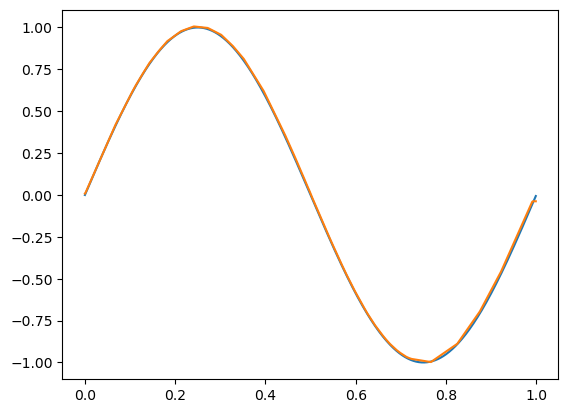

In [22]:
X_test, y_test = sine_data()

dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)

plt.plot(X_test, y_test)
plt.plot(X_test, activation3.output)
plt.show()